In [2]:
import random

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import linregress
import signac
#from cmeutils.sampling import equil_sample
from utils import check_job_for_log_equilibrium
from cmeutils.polymers import persistence_length

#custom_rc_params = matplotlib.rc_params_from_file("../matplotlibrc")
#matplotlib.rcParams.update(custom_rc_params)
import gsd.hoomd
import MDAnalysis as mda
from MDAnalysis.analysis import polymer

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



In [3]:
def power_scale(x, b):
    return x**b

# Matplotlib RC Params:    
color_dict = {1.0: "#0F0E0F", 0.8: "#666666", 0.7: "#964d4d", 0.6: "#d03f3f"}
symbol_dict = {1.0: "o", 0.8: "s", 0.7: "^", 0.6: "d"}
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["axes.labelsize"] = 10
plt.rcParams["legend.fontsize"] = 7
plt.rcParams['lines.markersize'] = 3
plt.rcParams["lines.linestyle"] = "-"
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["figure.dpi"] = 1200
plt.rcParams["legend.markerscale"] = 1

SAVE_FIGS = True
length_unit = "$[\sigma$]"

# Single Chains

In [4]:
cg_single_chain_proj = signac.get_project("../../testing-model/model-with-no-dihedrals/single-chains/")
target_single_chain_proj = signac.get_project("../../training-runs/single-chains/")
ss_target_job = target_single_chain_proj.open_job(id="29a7f0d216700e7c8534b8c11140ba06")

## Check for equilibration:

In [14]:
for job in cg_single_chain_proj.find_jobs({"doc.equilibrated": False}):
#for job in target_single_chain_proj.find_jobs({"doc.equilibrated": False}):
    if job.doc.runs != 0:
        check_job_for_log_equilibrium(job, trim_cut=100)

## Chain Stiffness (Persistence Length)

In [5]:
def persistence_length(gsd_file, start, stop):
    u = mda.Universe(gsd_file)
    chains = u.atoms.fragments
    backbones = [chain.select_atoms("name A A") for chain in chains]
    sorted_backbones = [polymer.sort_backbone(bb) for bb in backbones]
    pl = polymer.PersistenceLength(sorted_backbones)
    pl.run(start=start, stop=stop)
    return pl.lp


def lp_bootstrap_sampling(gsd_file, start_frame, window_size=25, n_samples=10):
    with gsd.hoomd.open(gsd_file) as traj:
        n_frames = len(traj)
        
    random_starts = random.sample(range(start_frame, n_frames-window_size), n_samples)
    
    lp_results = []
    for start in random_starts:
        lp = persistence_length(gsd_file=gsd_file, start=start, stop=start+window_size)
        lp_results.append(lp)
        
    return np.mean(lp_results), np.std(lp_results)

In [26]:
for job in cg_single_chain_proj.find_jobs(filter={"periodic_dihedrals": True}):
    gsd_path = job.fn(f"trajectory{1-job.doc.runs}.gsd")
    lp_mean, lp_std = lp_bootstrap_sampling(gsd_file=gsd_path, start_frame=100)
    job.doc.lp_mean = lp_mean
    job.doc.lp_std = lp_std

/home/chrisjones4/miniconda3/envs/pps-msibi/lib/python3.11/site-packages/MDAnalysis/analysis/base.py:447: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[i] = ts.time
/home/chrisjones4/miniconda3/envs/pps-msibi/lib/python3.11/site-packages/MDAnalysis/analysis/polymer.py:275: DeprecationWarning: The `lp` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.variance` instead.
  warnings.warn(wmsg, DeprecationWarning)
/home/chrisjones4/miniconda3/envs/pps-msibi/lib/python3.11/site-packages/synced_collections/numpy_utils.py:46: NumpyConversionWarning: Any numpy types provided will be transparently converted to the closest base Python equivalents.
  warnings.warn(NUMPY_CONVERSION_WARNING, NumpyConversionWarning)


## Chain statistics scaling: C.G. Model

### Radius of Gyration:

In [ ]:
fig = plt.figure()

for kT in [5.0, 6.0, 7.0, 8.0]:
    x = []
    y = []
    y_err = []
    for chain_length, jobs in cg_single_chain_proj.find_jobs(
        {"doc.sampled": True, "kT": kT}).groupby("lengths"):
        for job in jobs:
            x.append(chain_length)
            y.append(job.doc.rg_avg)
            y_err.append(job.doc.rg_std)
    popt, pcov = curve_fit(power_scale, x, y, p0=0.5)
    plt.errorbar(
        x=x,
        y=y,
        yerr=y_err,
        marker="o",
        label=(kT, np.round(popt[0], 2))
    )

plt.legend(title="(kT, $b_{R_g})$")
plt.xlabel("Chain Length (N)")
plt.ylabel(f"$<R_g>$ {length_unit}")
plt.tight_layout()

if SAVE_FIGS:
    plt.savefig("../FIGS/rg-scaling-cg-model.png")
plt.show()

In [ ]:
fig = plt.figure()

for kT in [5.0, 6.0, 7.0, 8.0]:
    x = []
    y = []
    for chain_length, jobs in cg_single_chain_proj.find_jobs(
        {"doc.sampled": True, "kT": kT}).groupby("lengths"):
        for job in jobs:
            x.append(np.log(chain_length))
            y.append(np.log(job.doc.rg_avg))
    slope, intercept, r, p, se = linregress(x=x, y=y)
    plt.plot(x, y, label=(kT, np.round(slope, 2)), marker="o")

plt.legend(title="(kT, Slope)")
plt.xlabel("$\ln(N)$")
plt.ylabel(f"$\ln(<R_g>$ {length_unit})")
plt.tight_layout()

if SAVE_FIGS:
    plt.savefig("../FIGS/log-rg-scaling-cg-model.png")
plt.show()

### End-to-End Distance:

In [ ]:
fig = plt.figure()

for kT in [5.0, 6.0, 7.0, 8.0]:
    x = []
    y = []
    y_err = []
    for chain_length, jobs in cg_single_chain_proj.find_jobs(
        {"doc.sampled": True, "kT": kT}).groupby("lengths"):
        for job in jobs:
            x.append(chain_length)
            y.append(job.doc.re_avg)
            y_err.append(job.doc.re_std)
    popt, pcov = curve_fit(power_scale, x, y, p0=0.5)
    plt.errorbar(
        x=x,
        y=y,
        yerr=y_err,
        marker="o",
        label=(kT, np.round(popt[0], 3))
    )

plt.legend(title="(kT, $b_{Re})$", loc="upper left")
plt.xlabel("Chain Length (N)")
plt.ylabel(f"$<R_e>$ {length_unit}")
plt.tight_layout()

if SAVE_FIGS:
    plt.savefig("../FIGS/re-scaling-cg-model.png")
plt.show()

In [ ]:
fig = plt.figure()

for kT in [5.0, 6.0, 7.0, 8.0]:
    x = []
    y = []
    for chain_length, jobs in cg_single_chain_proj.find_jobs(
        {"doc.sampled": True, "kT": kT}).groupby("lengths"):
        for job in jobs:
            x.append(np.log(chain_length))
            y.append(np.log(job.doc.re_avg))
            
    slope, intercept, r, p, se = linregress(x=x, y=y)
    plt.plot(x, y, label=(kT, np.round(slope, 2)), marker="o")

plt.legend(title="(kT, Slope)")
plt.xlabel("$\ln(N)$")
plt.ylabel(f"$\ln(<R_e>$ {length_unit})")
plt.tight_layout()

if SAVE_FIGS:
    plt.savefig("../FIGS/log-re-scaling-cg-model.png")
plt.show()

# Chain Statistics: Compare Target to C.G.

In [6]:
chain_lengths = [20, 40, 60, 80]
kT = 7.0

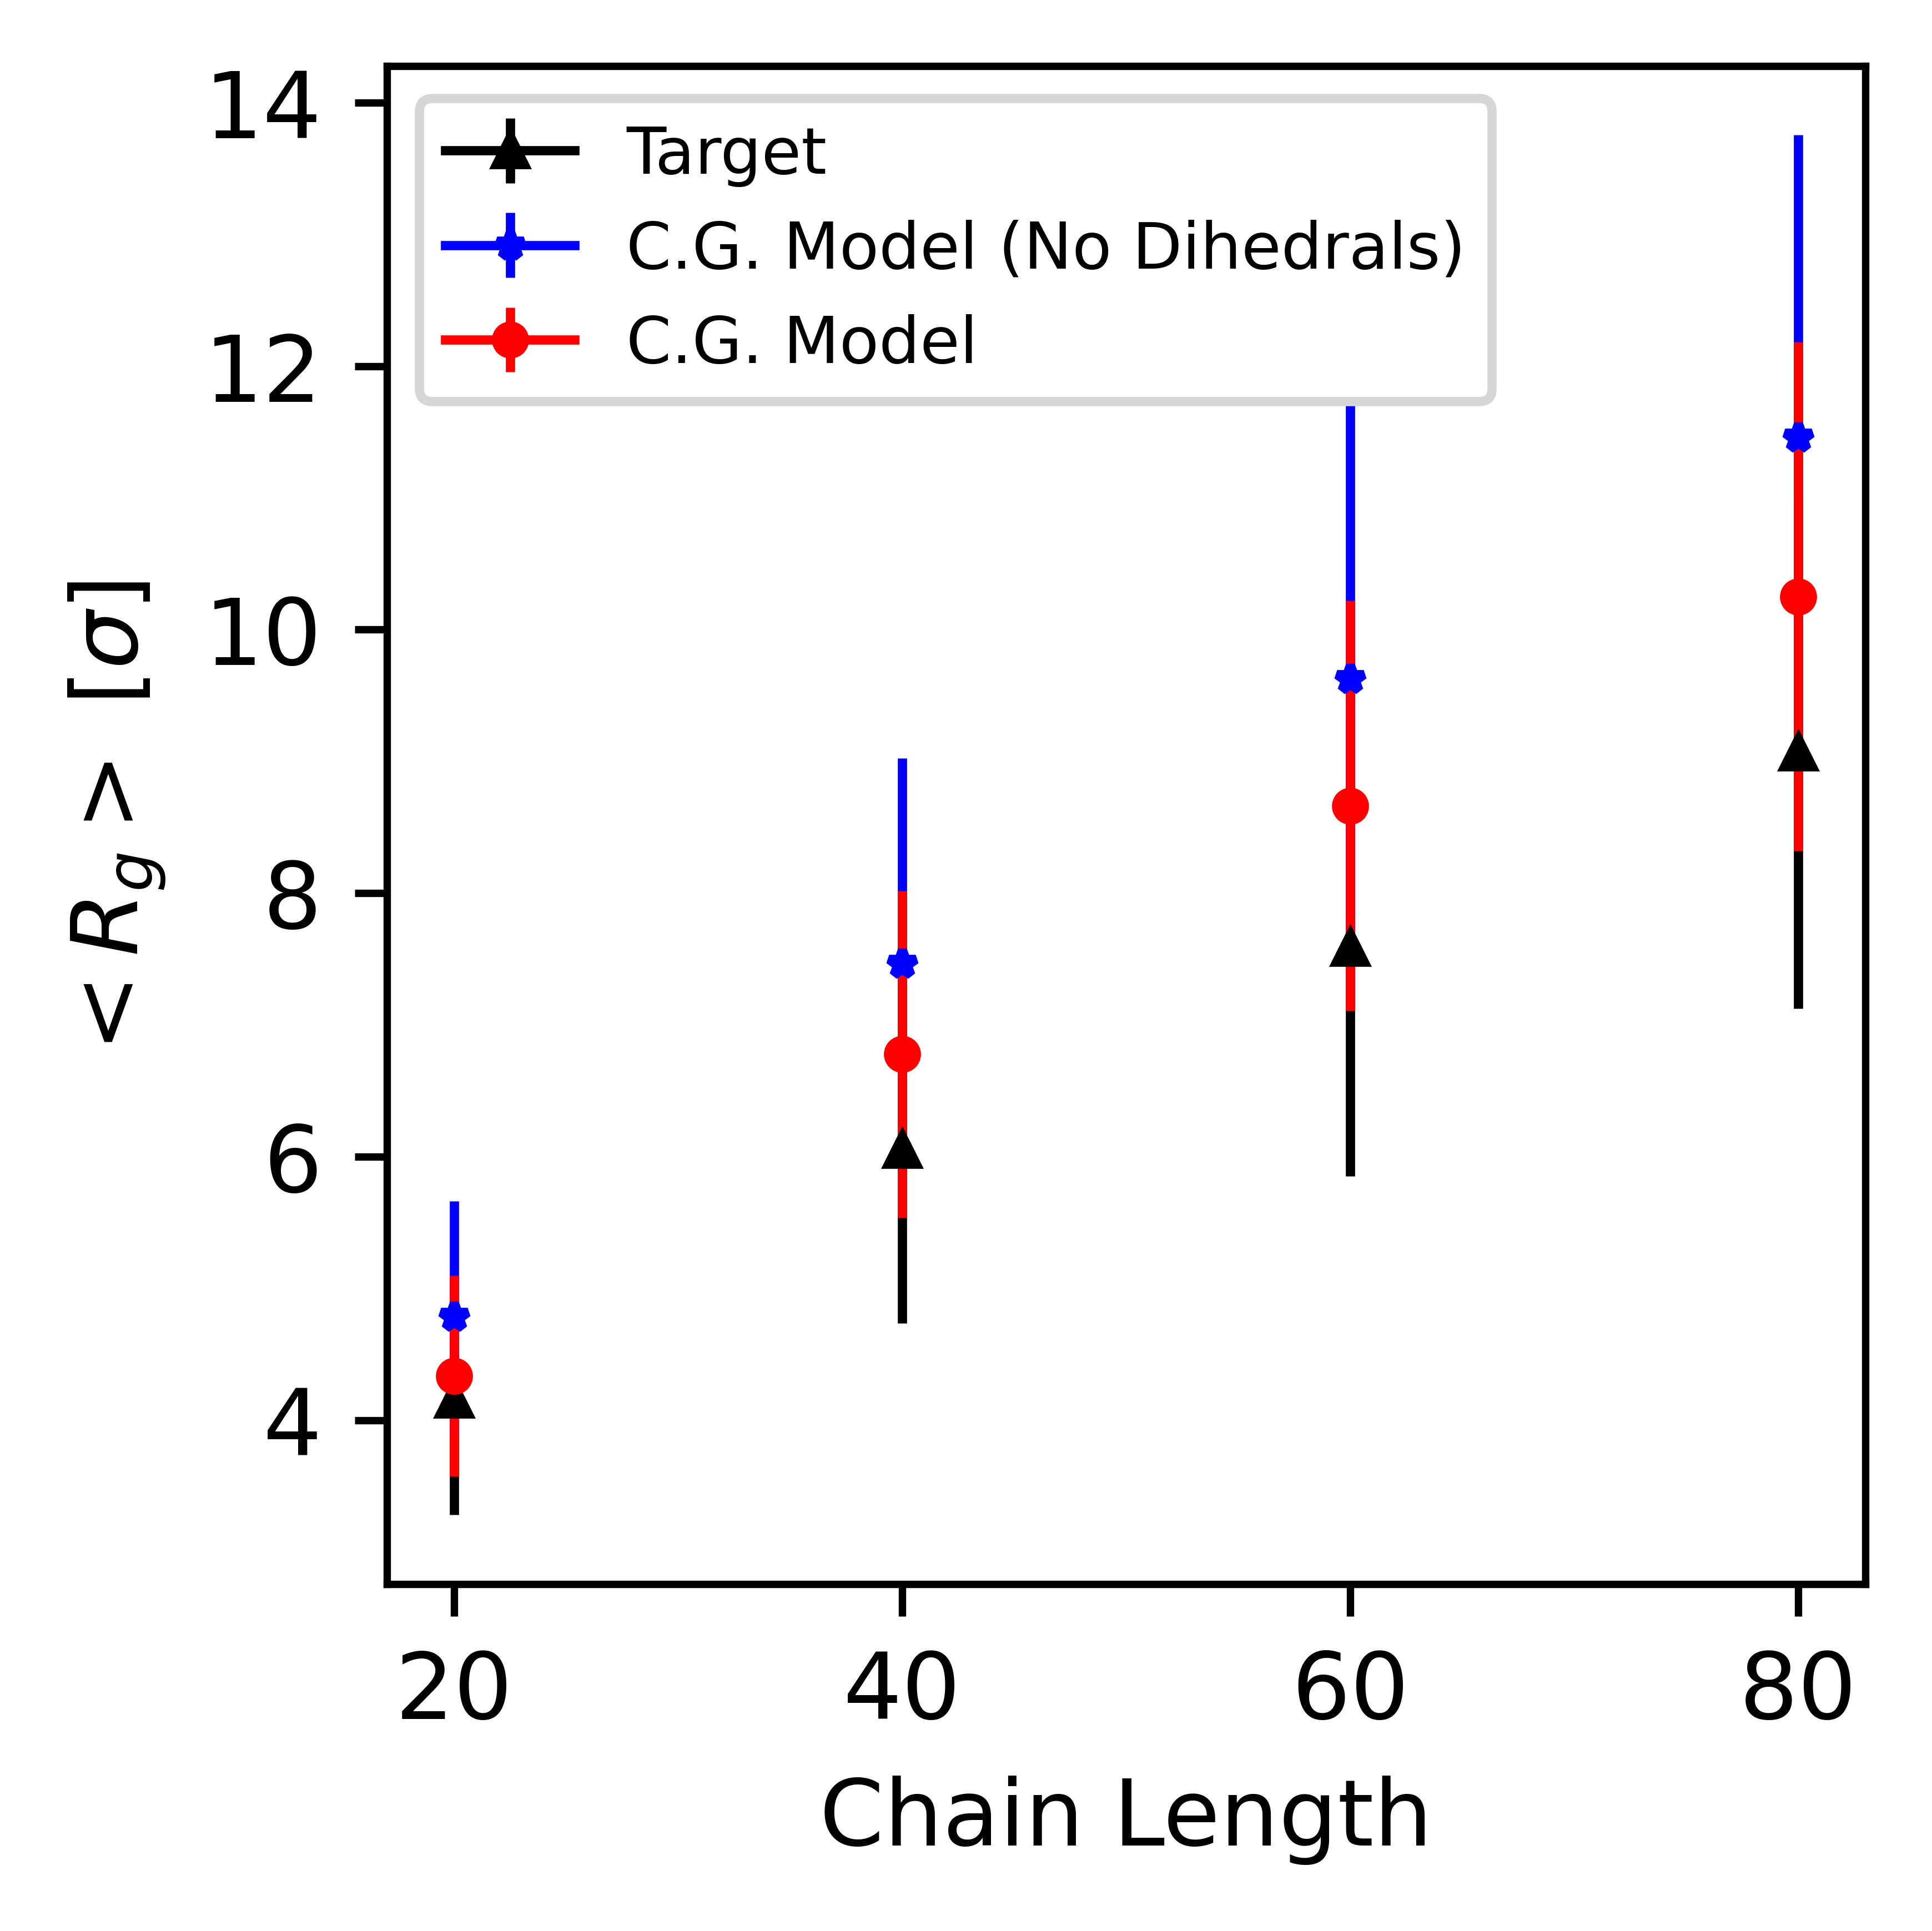

In [10]:
fig = plt.figure()
target_proj_fiter = {"kT": kT, "remove_hydrogens": True}

count = 0
for length, jobs in target_single_chain_proj.find_jobs(target_proj_fiter).groupby("lengths"):
    if length == 2:
        continue
    if count == 0:
        label = "Target"
    else:
        label = None
    for job in jobs:
        plt.errorbar(x=length, y=job.doc.rg_avg, yerr=job.doc.rg_std, marker="^", c="k", label=label)
    count += 1

count = 0
for length, jobs in cg_single_chain_proj.find_jobs({"kT": kT, "periodic_dihedrals": False}).groupby("lengths"):
    if length not in chain_lengths:
        continue
    if count == 0:
        label = "C.G. Model (No Dihedrals)"
    else:
        label = None
    for job in jobs:
        plt.errorbar(x=length, y=job.doc.rg_avg, yerr=job.doc.rg_std, marker="*", c="blue", label=label)
        count += 1

count = 0
for length, jobs in cg_single_chain_proj.find_jobs({"kT": kT, "periodic_dihedrals": True}).groupby("lengths"):
    if length not in chain_lengths:
        continue
    if count == 0:
        label = "C.G. Model"
    else:
        label = None
    for job in jobs:
        plt.errorbar(x=length, y=job.doc.rg_avg, yerr=job.doc.rg_std, marker="o", c="r", label=label)
        count += 1
        

plt.legend(loc="upper left")
plt.xlabel("Chain Length")
plt.ylabel(f"$<R_g>$ {length_unit}")
plt.tight_layout()

if SAVE_FIGS:
    plt.savefig("../../FIGS/rg-compare-models-SI.png")
plt.show()

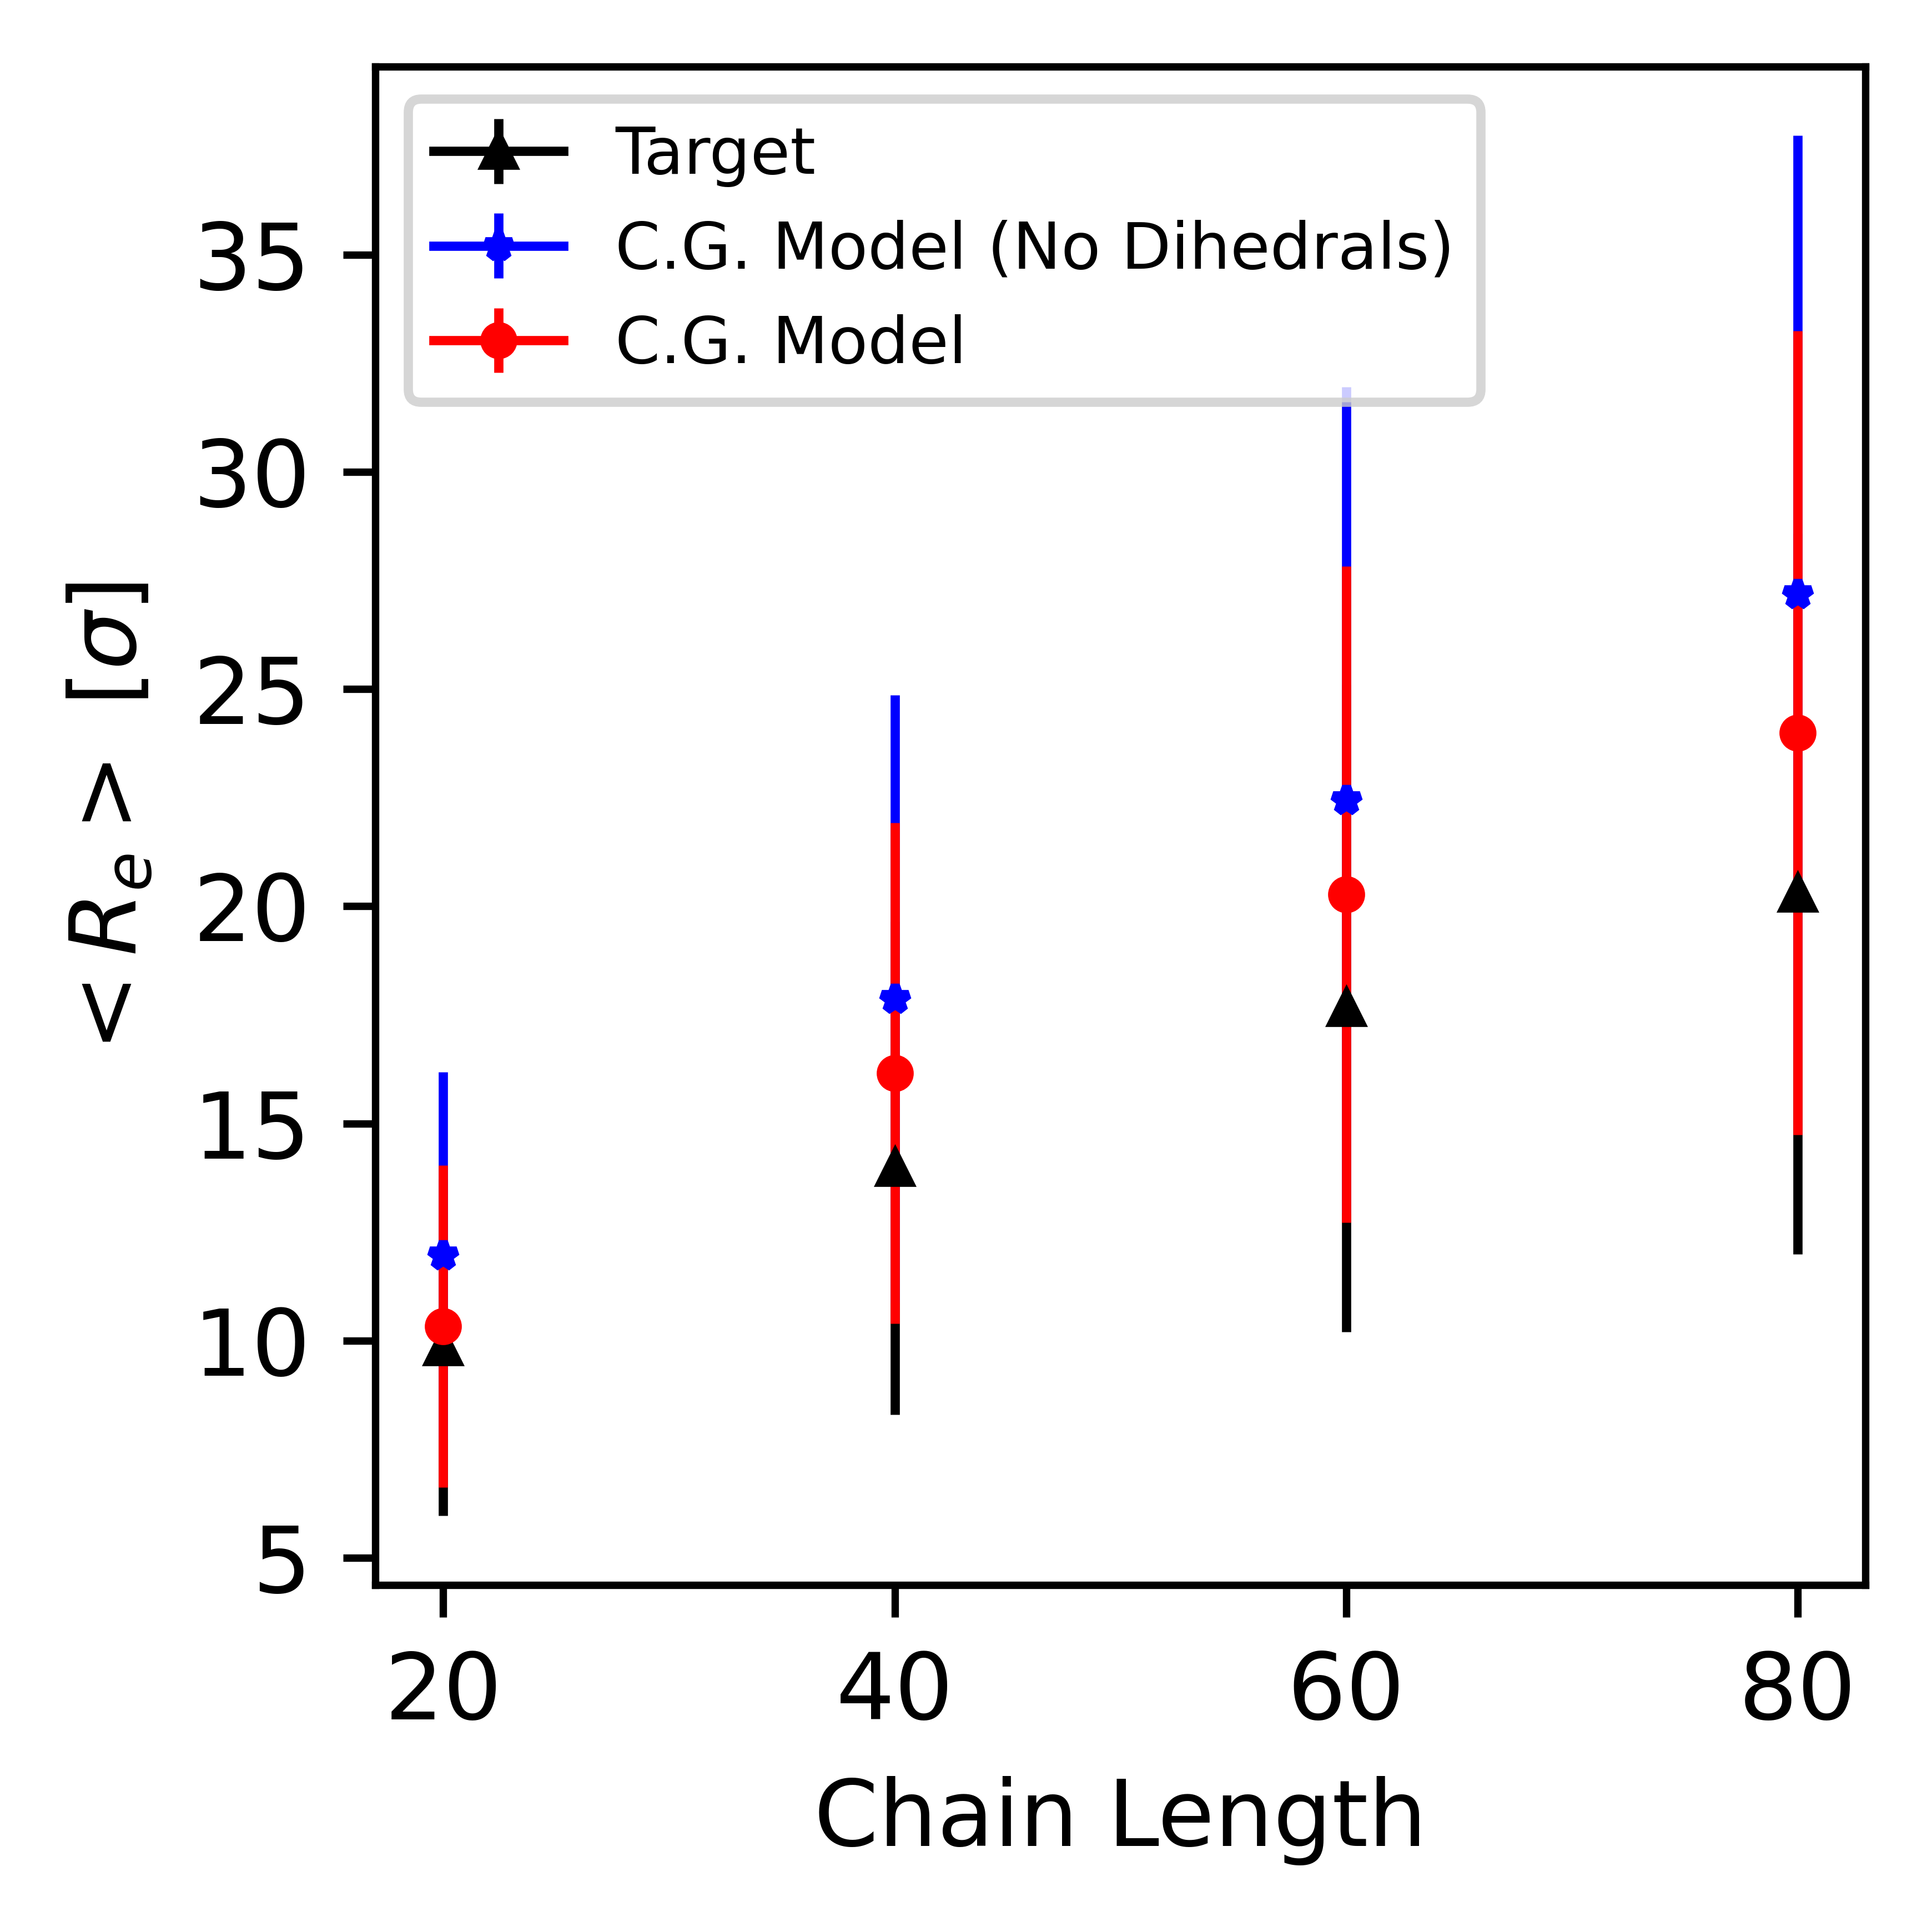

In [11]:
fig = plt.figure()
target_proj_fiter = {"kT": kT, "remove_hydrogens": True}

count = 0
for length, jobs in target_single_chain_proj.find_jobs(target_proj_fiter).groupby("lengths"):
    if length == 2:
        continue
    if count == 0:
        label = "Target"
    else:
        label = None
    for job in jobs:
        plt.errorbar(x=length, y=job.doc.re_avg, yerr=job.doc.re_std, marker="^", c="k", label=label)
    count += 1

count = 0
for length, jobs in cg_single_chain_proj.find_jobs({"kT": kT, "periodic_dihedrals": False}).groupby("lengths"):
    if length not in chain_lengths:
        continue
    if count == 0:
        label = "C.G. Model (No Dihedrals)"
    else:
        label = None
    for job in jobs:
        plt.errorbar(x=length, y=job.doc.re_avg, yerr=job.doc.re_std, marker="*", c="blue", label=label)
        count += 1

count = 0
for length, jobs in cg_single_chain_proj.find_jobs({"kT": kT, "periodic_dihedrals": True}).groupby("lengths"):
    if length not in chain_lengths:
        continue
    if count == 0:
        label = "C.G. Model"
    else:
        label = None
    for job in jobs:
        plt.errorbar(x=length, y=job.doc.re_avg, yerr=job.doc.re_std, marker="o", c="r", label=label)
        count += 1
        
plt.legend(loc="upper left")
plt.xlabel("Chain Length")
plt.ylabel(f"$<R_e>$ {length_unit}")
plt.tight_layout()

if SAVE_FIGS:
    plt.savefig("../../FIGS/re-compare-models-SI.png")
plt.show()

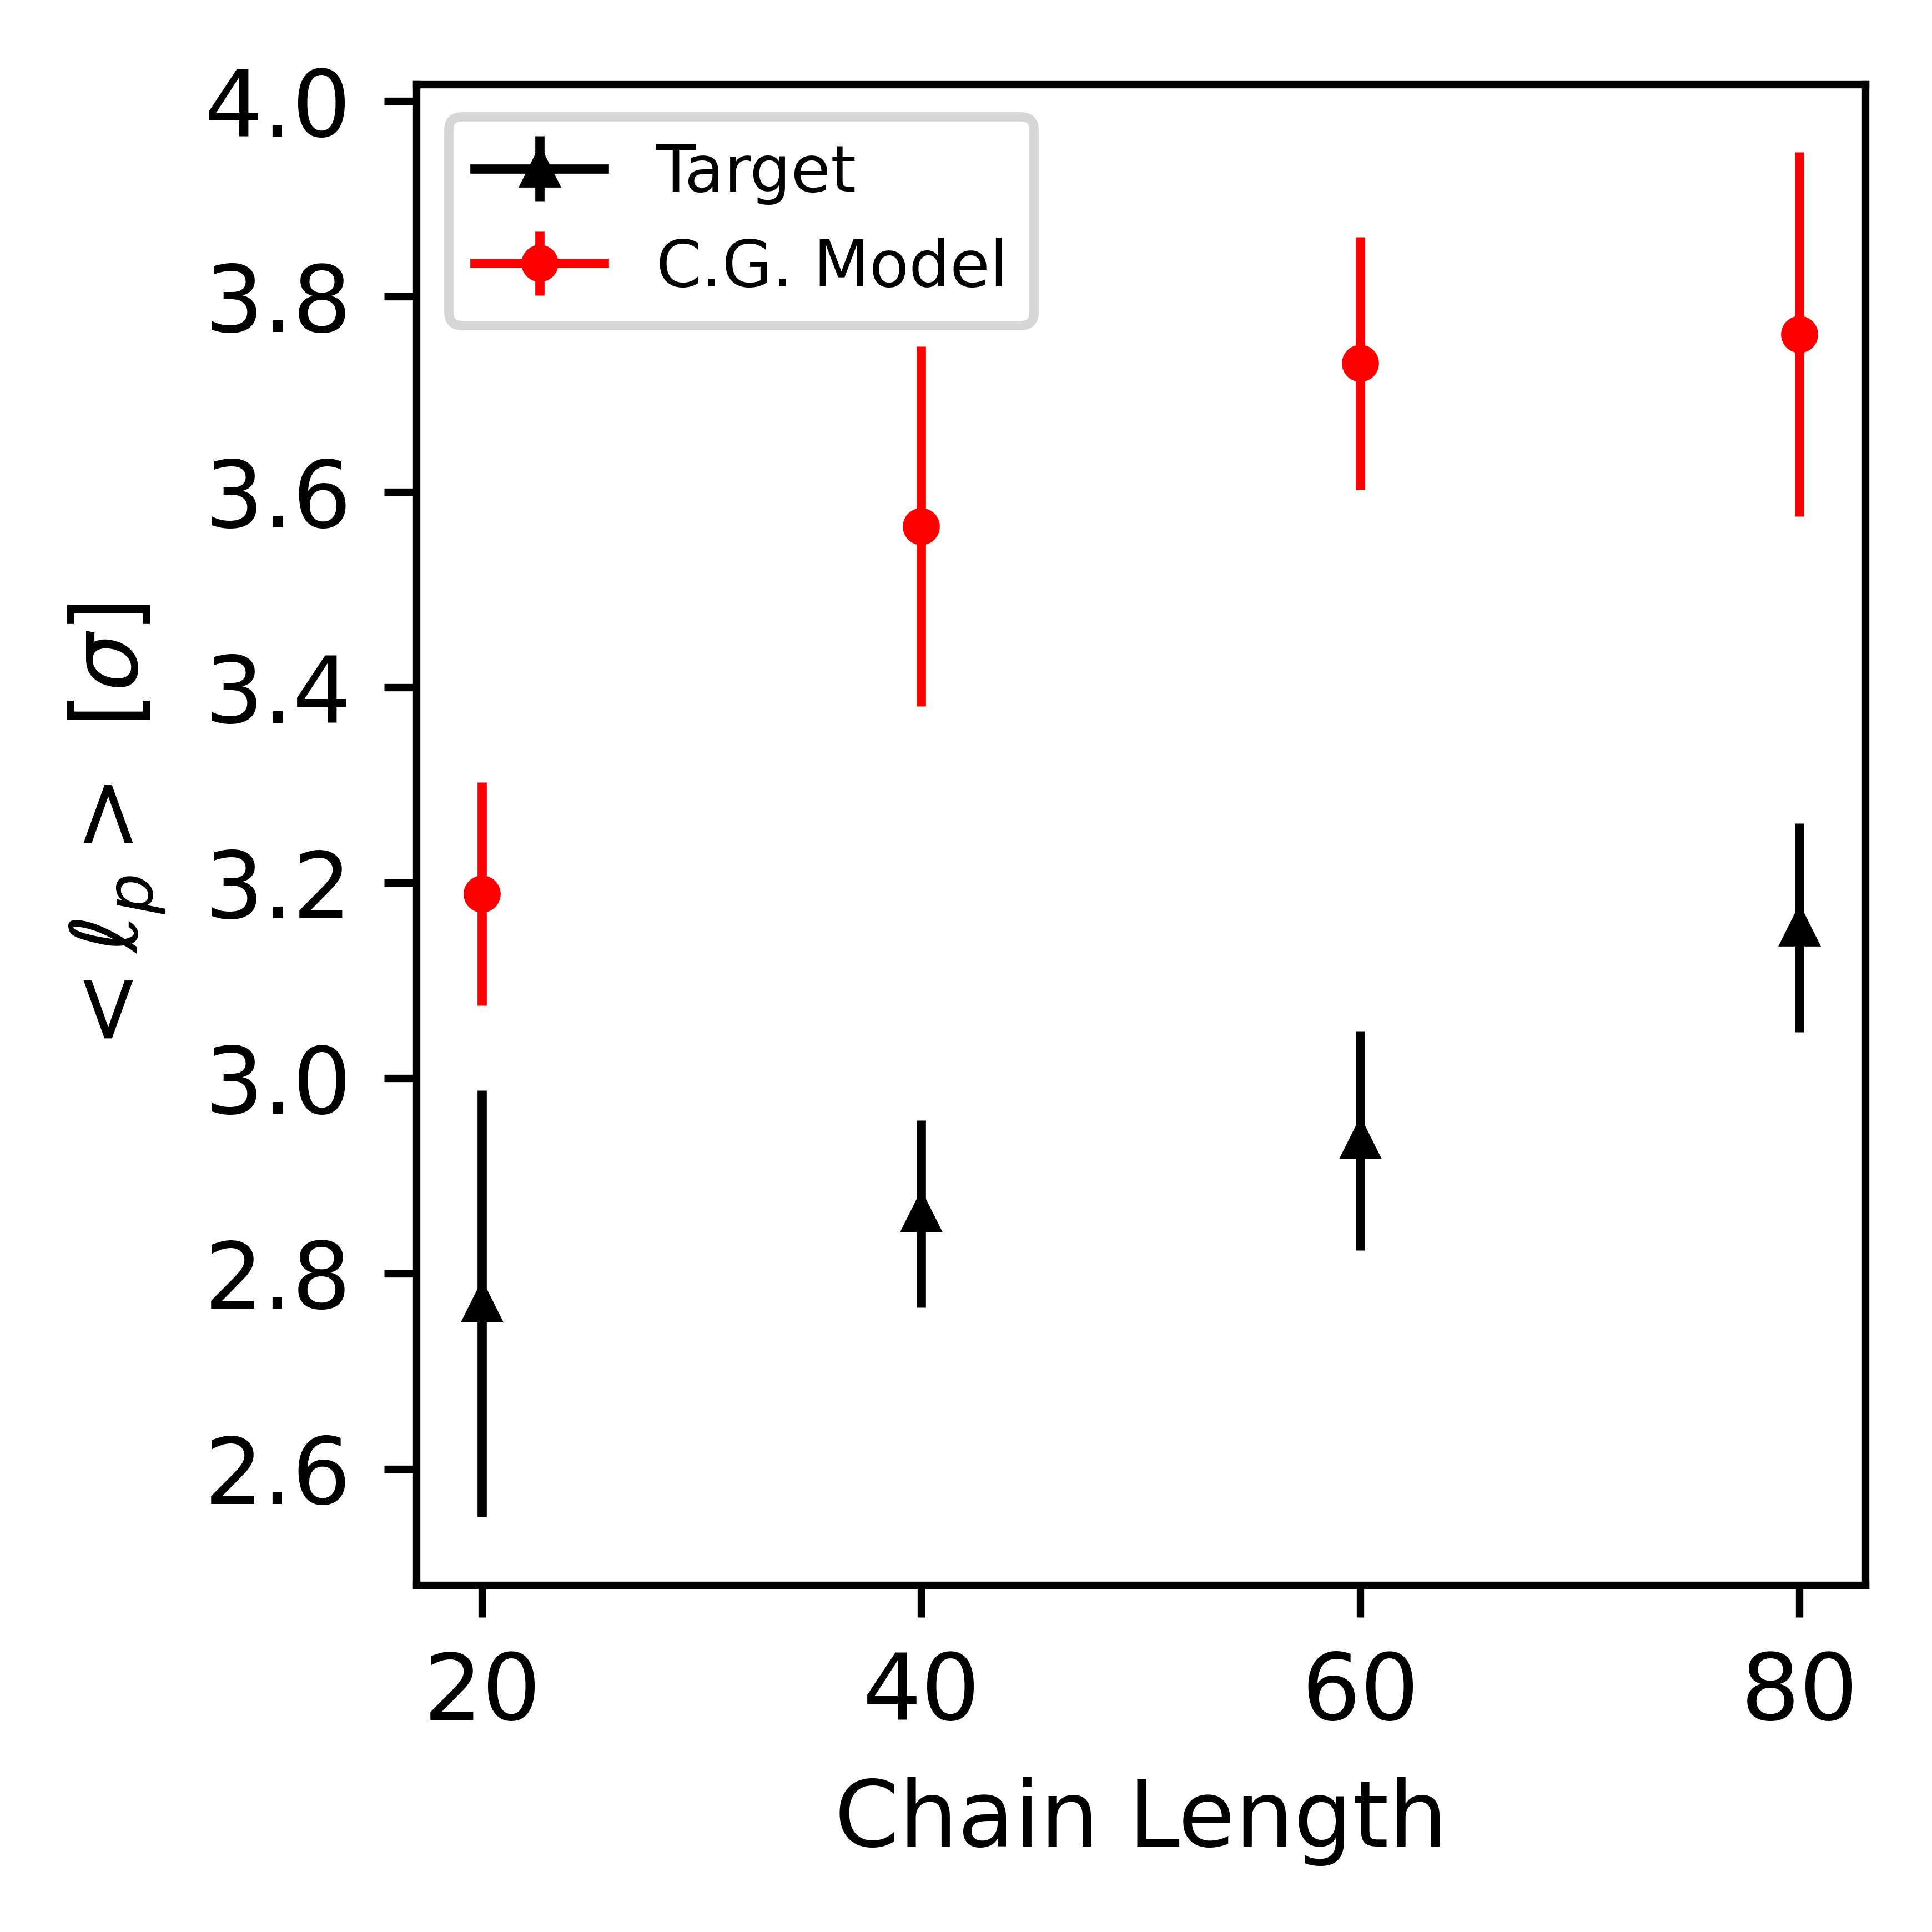

In [16]:
fig = plt.figure()
target_proj_fiter = {"kT": kT, "remove_hydrogens": True}

count = 0
for length, jobs in target_single_chain_proj.find_jobs(target_proj_fiter).groupby("lengths"):
    if length == 2:
        continue
    if count == 0:
        label = "Target"
    else:
        label = None
    for job in jobs:
        plt.errorbar(x=length, y=job.doc.lp_mean, yerr=job.doc.lp_std, marker="^", c="k", label=label)
    count += 1

#count = 0
#for length, jobs in cg_single_chain_proj.find_jobs({"kT": kT, "periodic_dihedrals": False}).groupby("lengths"):
#    if length not in chain_lengths:
#        continue
#    if count == 0:
#        label = "C.G. Model (No Dihedrals)"
#    else:
#        label = None
#    for job in jobs:
#        plt.errorbar(x=length, y=job.doc.lp_mean, yerr=job.doc.lp_std, marker="*", c="blue", label=label)
#        count += 1

count = 0
for length, jobs in cg_single_chain_proj.find_jobs({"kT": kT, "periodic_dihedrals": True}).groupby("lengths"):
    if length not in chain_lengths:
        continue
    if count == 0:
        label = "C.G. Model"
    else:
        label = None
    for job in jobs:
        plt.errorbar(x=length, y=job.doc.lp_mean, yerr=job.doc.lp_std, marker="o", c="r", label=label)
        count += 1
        
plt.legend(loc="upper left")
plt.xlabel("Chain Length")
#plt.ylim(2.4, 6.2)
plt.ylabel(f"$<\ell_p>$ {length_unit}")
plt.tight_layout()

if SAVE_FIGS:
    plt.savefig("../../FIGS/lp-compare-models.png")
plt.show()